In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from utils import *

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import folium

import xgboost as xgb

from sklearn.metrics import root_mean_squared_error

import optuna
from optuna.trial import TrialState

#### Carregando o dataset

In [3]:
dir = 'balanced_data'

In [4]:
df_train = pd.read_csv(f'../data/{dir}/train.csv')
df_val = pd.read_csv(f'../data/{dir}/validation.csv')
df_test = pd.read_csv(f'../data/{dir}/test.csv')

In [5]:
df_train.head()

ponto_id  rssi_1_1  rssi_1_2  rssi_1_3  rssi_2_1  rssi_2_2  rssi_2_3  \
0      6659  0.490595  0.592069  0.473746  0.305143  0.748657  0.867459   
1      4799  0.316859  0.000000  0.303716  0.000000  0.209296  0.239055   
2      7057  0.420978  0.374651  0.412409  0.261084  0.398934  0.492072   
3      7408  0.472425  0.307408  0.482708  0.224991  0.264643  0.472029   
4      6959  0.534422  0.307408  0.539420  0.259290  0.264643  0.523022   

   rssi_3_1  rssi_3_2  rssi_3_3   delay_1   delay_2   delay_3       lat  \
0  0.332333  0.426865  0.306476  1.000000  0.285714  0.714286 -8.058890   
1  0.124152  0.277901  0.000000  0.666667  0.428571  0.285714 -8.055506   
2  0.773747  0.712558  0.294188  0.666667  0.571429  0.142857 -8.055580   
3  0.816936  0.455887  0.855267  0.666667  0.857143  0.000000 -8.054870   
4  0.389744  0.515420  0.671150  0.833333  0.857143  0.000000 -8.055760   

         lon  indoor  
0 -34.946260   False  
1 -34.951693    True  
2 -34.954590   False  
3 -34.957800   False  
4 -34.958900   False

In [6]:
# Confirmando que não há data leak
assert len(set(df_train['ponto_id']).intersection(set(df_val['ponto_id']))) == 0
assert len(set(df_train['ponto_id']).intersection(set(df_test['ponto_id']))) == 0
assert len(set(df_val['ponto_id']).intersection(set(df_test['ponto_id']))) == 0

In [7]:
X_train = df_train.drop(['ponto_id', 'indoor', 'lat', 'lon'], axis=1).values
y_train = df_train[['lat', 'lon']].values

X_val = df_val.drop(['ponto_id', 'indoor', 'lat', 'lon'], axis=1).values
y_val = df_val[['lat', 'lon']].values

X_test = df_test.drop(['ponto_id', 'indoor', 'lat', 'lon'], axis=1).values
y_test = df_test[['lat', 'lon']].values

#### Criando o modelo base

In [8]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [9]:
params = {
    'max_depth': 8, #
    'eta': 0.2,  #Learning Rate
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_delta_step': 3, # [1-10]
    'lambda': 1, # L2 Reg
    'alpha': 0, # L1 Reg
}

In [11]:
model = xgb.train(
    params,
    dtrain,
    100,
    evals=[(dval, 'validation')],
    early_stopping_rounds=5
)

[0]	validation-rmse:12.84921
[1]	validation-rmse:12.24921
[2]	validation-rmse:11.64921
[3]	validation-rmse:11.04921
[4]	validation-rmse:10.44921
[5]	validation-rmse:9.84921
[6]	validation-rmse:9.24921
[7]	validation-rmse:8.64921
[8]	validation-rmse:8.04921
[9]	validation-rmse:7.44921
[10]	validation-rmse:6.84921
[11]	validation-rmse:6.24921
[12]	validation-rmse:5.64921
[13]	validation-rmse:5.04921
[14]	validation-rmse:4.44921
[15]	validation-rmse:3.84921
[16]	validation-rmse:3.24921
[17]	validation-rmse:2.64921
[18]	validation-rmse:2.11942
[19]	validation-rmse:1.69559
[20]	validation-rmse:1.35650
[21]	validation-rmse:1.08523
[22]	validation-rmse:0.86821
[23]	validation-rmse:0.69458
[24]	validation-rmse:0.55568
[25]	validation-rmse:0.44456
[26]	validation-rmse:0.35566
[27]	validation-rmse:0.28454
[28]	validation-rmse:0.22764
[29]	validation-rmse:0.18213
[30]	validation-rmse:0.14572
[31]	validation-rmse:0.11658
[32]	validation-rmse:0.09328
[33]	validation-rmse:0.07464
[34]	validation-rms

#### Avaliando o modelo

In [12]:
y_pred = model.predict(dtest)
rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

RMSE: 0.014225202675394896


In [13]:
accuracy = calculate_accuracy(y_pred, y_test)
print(f"Acurácia: {accuracy:.3f}")

Acurácia: 0.652


Erro de localização médio, mínimo, máximo e desvio-padrão

In [14]:
distances = get_error_distances(y_pred, y_test)
print_errors(distances)

Erro de localização médio: 18.598 metros
Erro mínimo: 0.09195697994442176 metros
Erro máximo: 160.124 metros
Desvio Padrão do erro: 25.625 metros


### Visualização dos erros

Boxplot

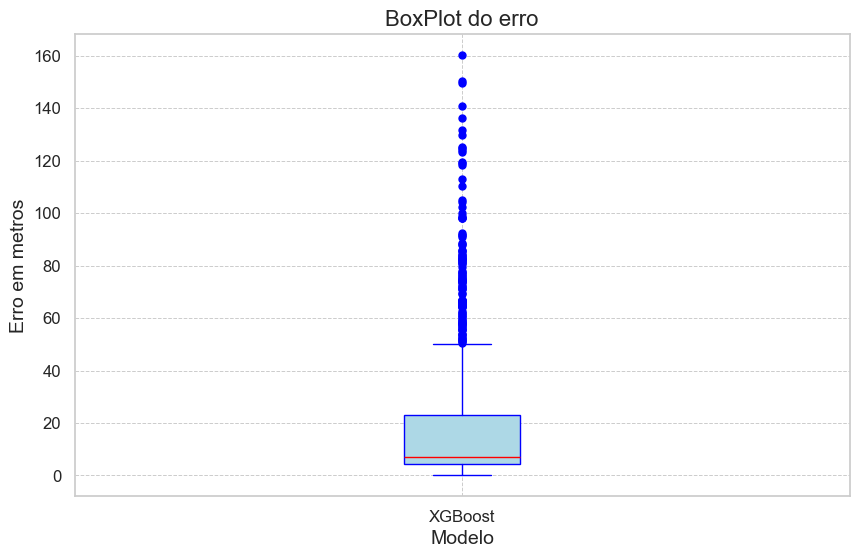

In [15]:
plot_boxplot('XGBoost', distances)

Histograma

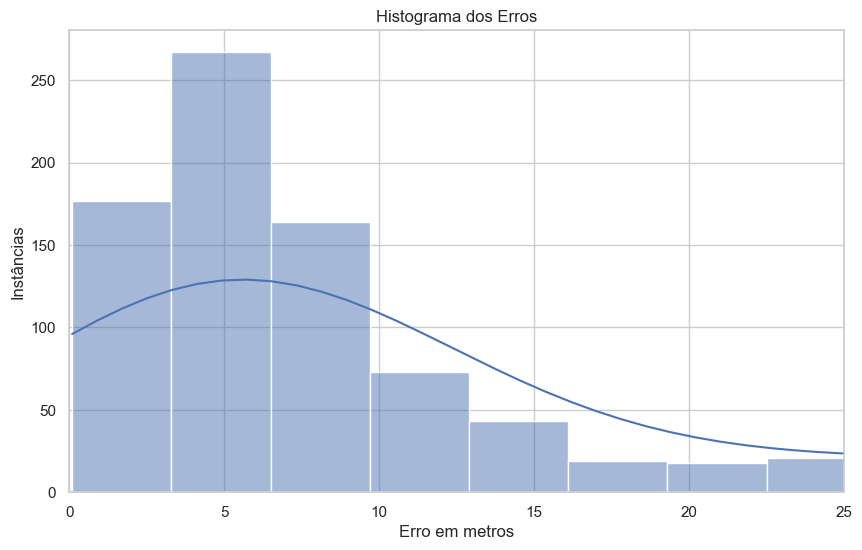

In [16]:
plot_histogram(distances)

Mapa dos Pontos Reais X Pontos Preditos

In [17]:
map = plot_folium_map(y_test, y_pred, connect_point=True)
map

### Grid Search

In [18]:
param_grid = {
    'max_depth': [6, 8, 10, 12], #
    'eta': [0.1, 0.15, 0.2, 0.25, 0.3],  #Learning Rate
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_delta_step': [1, 2, 3, 4, 5], # [1-10]
    'lambda': [1, 2, 3], # L2 Reg
    'alpha': [0, 1, 2], # L1 Reg
}

In [19]:
def xgboost_grid_search(params, dtrain, dval, dtest, y_test, metric='RMSE'):
    best_err = np.inf
    for max_depth in params['max_depth']:
        for eta in params['eta']:
            for max_delta_step in params['max_delta_step']:
                for lambd in params['lambda']:
                    for alpha in params['alpha']:
                        p = {
                            'max_depth': max_depth,
                            'eta': eta,
                            'objective': 'reg:squarederror',
                            'eval_metric': 'rmse',
                            'max_delta_step': max_delta_step,
                            'lambda': lambd,
                            'alpha': alpha
                        }
                        
                        model = xgb.train(
                            p,
                            dtrain,
                            250,
                            evals=[(dval, 'validation')],
                            early_stopping_rounds=7
                        )
                        
                        y_pred = model.predict(dtest)
                        if metric == 'RMSE':
                            err = np.sqrt(root_mean_squared_error(y_test, y_pred))
                            print(f"\nRMSE: {rmse:.5f}\n")  
                        else:
                            distances = get_error_distances(y_pred, y_test)
                            err = sum(distances) / len(distances)
                            print(f"\nDistância Média: {err:.5f}\n")

                        if err < best_err:
                            best_err = err
                            best_model = model

    return best_model

In [20]:
model = xgboost_grid_search(param_grid, dtrain, dval, dtest, y_test, 'DIST')

[0]	validation-rmse:13.34921
[1]	validation-rmse:13.24921
[2]	validation-rmse:13.14921
[3]	validation-rmse:13.04921
[4]	validation-rmse:12.94921
[5]	validation-rmse:12.84921
[6]	validation-rmse:12.74921
[7]	validation-rmse:12.64921
[8]	validation-rmse:12.54921
[9]	validation-rmse:12.44921
[10]	validation-rmse:12.34921
[11]	validation-rmse:12.24921
[12]	validation-rmse:12.14921
[13]	validation-rmse:12.04921
[14]	validation-rmse:11.94921
[15]	validation-rmse:11.84921
[16]	validation-rmse:11.74921
[17]	validation-rmse:11.64921
[18]	validation-rmse:11.54921
[19]	validation-rmse:11.44921
[20]	validation-rmse:11.34921
[21]	validation-rmse:11.24920
[22]	validation-rmse:11.14920
[23]	validation-rmse:11.04920
[24]	validation-rmse:10.94920
[25]	validation-rmse:10.84920
[26]	validation-rmse:10.74920
[27]	validation-rmse:10.64920
[28]	validation-rmse:10.54920
[29]	validation-rmse:10.44920
[30]	validation-rmse:10.34920
[31]	validation-rmse:10.24920
[32]	validation-rmse:10.14920
[33]	validation-rmse

In [13]:
y_pred = model.predict(dtest)
rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse:.5f}')

RMSE: 0.01370


In [14]:
accuracy = calculate_accuracy(y_pred, y_test)
print(f"Acurácia: {accuracy:.5f}")

Acurácia: 0.64503


In [15]:
distances = get_error_distances(y_pred, y_test)
print_errors(distances)

Erro de localização médio: 17.044 metros
Erro mínimo: 0.3948599749347307 metros
Erro máximo: 198.894 metros
Desvio Padrão do erro: 23.973 metros


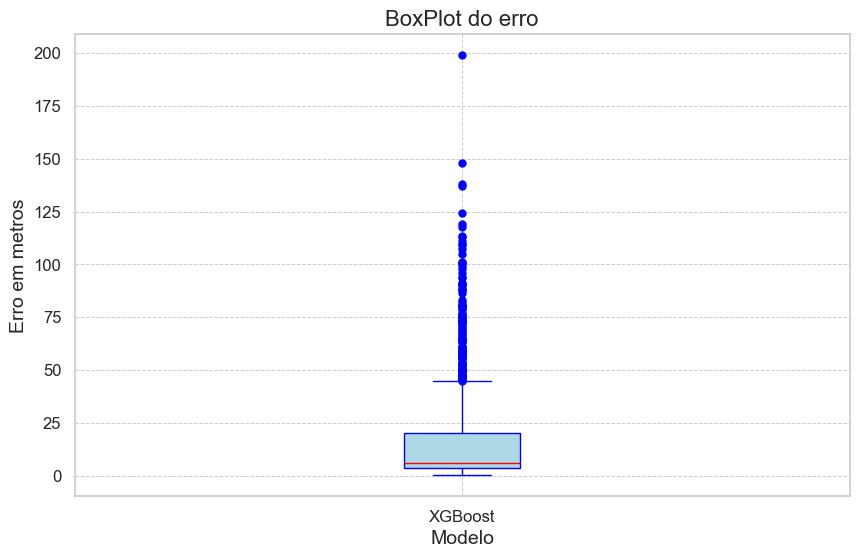

In [16]:
plot_boxplot('XGBoost', distances)

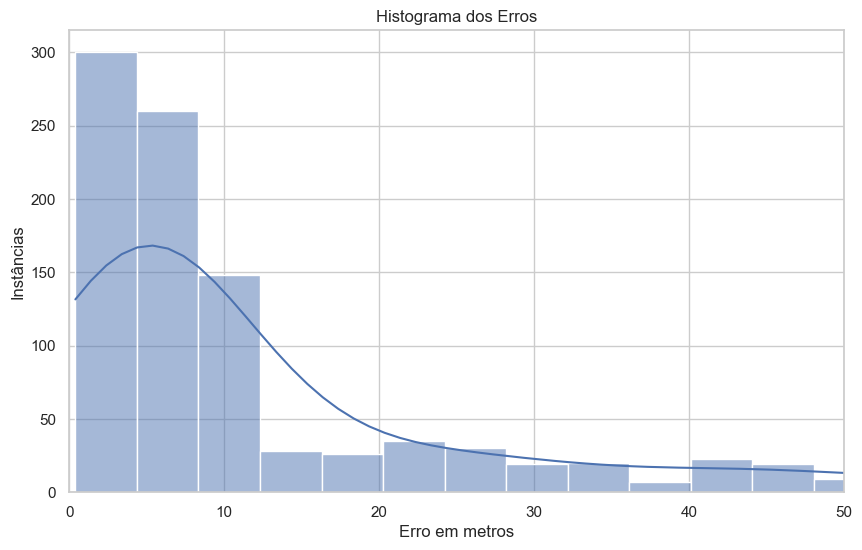

In [17]:
plot_histogram(distances, 50)

In [26]:
map = plot_folium_map(y_test, y_pred, connect_point=True)
map

#### Criação do arquivo de submit

In [14]:
# model = xgb.Booster()
# model.load_model("xgboost_model.json")

In [17]:
df_submit = pd.read_csv('../data/submit/Resultados_EquipeX_Metodo_Y.csv')

In [18]:
submit = df_submit.copy()
submit

ponto_id  rssi_1_1  rssi_1_2  rssi_1_3  rssi_2_1  rssi_2_2  rssi_2_3  \
0            0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1            3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2            8  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           10  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4           12  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...        ...       ...       ...       ...       ...       ...       ...   
2899      9672  0.683007  0.427860  0.745375  0.338093  0.372425  0.513271   
2900      9674  0.660574  0.614986  0.745375  0.265625  0.373545  0.378663   
2901      9675  0.696515  0.272818  0.650478  0.293126  0.272255  0.369109   
2902      9677  0.701844  0.508683  0.657285  0.240302  0.295898  0.347393   
2903      9678  0.661693  0.500826  0.793046  0.241918  0.409099  0.349584   

      rssi_3_1  rssi_3_2  rssi_3_3   delay_1   delay_2   delay_3  
0     0.317523  0.527387  0.000000  0.571429  0.428571  0.285714  
1     0.317523  0.527387  0.000000  0.571429  0.428571  0.285714  
2     0.317523  0.494311  0.000000  0.571429  0.428571  0.285714  
3     0.317523  0.527387  0.000000  0.571429  0.428571  0.285714  
4     0.317523  0.527387  0.000000  0.571429  0.428571  0.285714  
...        ...       ...       ...       ...       ...       ...  
2899  0.344011  0.199565  0.284662  0.000000  0.571429  0.571429  
2900  0.344011  0.199565  0.280179  0.000000  0.571429  0.571429  
2901  0.400705  0.199565  0.298351  0.000000  0.571429  0.571429  
2902  0.379110  0.199565  0.330972  0.000000  0.571429  0.714286  
2903  0.341010  0.199565  0.330972  0.000000  0.571429  0.714286  

[2904 rows x 13 columns]

In [19]:
df_submit = df_submit.drop(['ponto_id'], axis=1)

In [16]:
df_submit = df_submit.values

In [21]:
dsubmit = xgb.DMatrix(df_submit)

In [22]:
y_pred = model.predict(dsubmit)

In [23]:
submit['lat_pred'] = y_pred[:, 0]
submit['lon_pred'] = y_pred[:, 1]

In [24]:
submit.drop([
    'rssi_1_1', 'rssi_1_2', 'rssi_1_3',
    'rssi_2_1', 'rssi_2_2', 'rssi_2_3',
    'rssi_3_1', 'rssi_3_2', 'rssi_3_3',
    'delay_1', 'delay_2', 'delay_3'
], axis=1, inplace=True)

In [25]:
submit

ponto_id  lat_pred   lon_pred
0            0 -8.052703 -34.951702
1            3 -8.052703 -34.951702
2            8 -8.052703 -34.951702
3           10 -8.052703 -34.951702
4           12 -8.052703 -34.951702
...        ...       ...        ...
2899      9672 -8.046771 -34.952484
2900      9674 -8.046753 -34.952690
2901      9675 -8.047044 -34.952549
2902      9677 -8.046427 -34.951778
2903      9678 -8.046432 -34.951477

[2904 rows x 3 columns]

In [26]:
submit.to_csv(f'../data/submit/Resultados_Equipe5_Metodo_XGBoost.csv', index=False)